Develop a predictive model to predict at-risk customers who will turn over at a certain milestone.

Turnover rate: the proportion of customers who turned over during a given time period.

Scientific Steps:
1. Define problems;
2. Create hypothesis;
3. Design experiments;
4. Define metrics;

Python Pipeline:
1. Load data;
2. Explore data;
3. Build model;
4. Optimize model;

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import time
import math
from pandas.tools.plotting import table
from scipy import interp
from itertools import cycle
import datetime
%matplotlib inline
from imblearn.over_sampling import SMOTE
from sklearn import linear_model
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
import warnings
warnings.filterwarnings('ignore')

1. Load data

In [3]:
#. read in data.
dataframe = pd.read_csv('test_dataframe2.csv', index_col=0)
dataframe.shape

(8103, 10)

In [4]:
#. categorical variables -- > dummies variables
dataframe.head(10)

,score1,score2,category1,category2,category3,category4,labels,category5,category6,category7
id,,,,,,,,,,
1,24,0,1,1,3,0,1,52,2,0
2,24,0,1,1,3,5,1,25,2,0
3,0,0,0,0,0,0,1,32,1,2
4,19,0,1,0,4,5,1,20,1,0
5,18,0,0,3,1,0,1,36,1,0
6,21,0,1,1,0,0,1,22,2,0
7,24,0,1,0,3,0,1,55,1,0
8,20,0,1,1,0,5,1,23,2,0
9,23,0,1,1,1,0,1,28,2,0


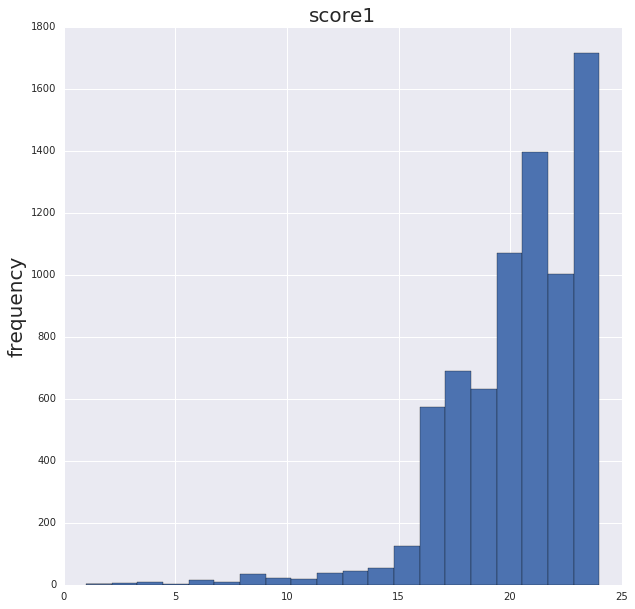

In [5]:
#. visualize numerical variable: score1
fig = plt.figure(figsize=(10,10))
score1 = dataframe['score1']
score1 = score1[score1>0]
plt.hist(score1.values, bins = 20)
plt.ylabel("frequency", fontsize=20)
plt.title('score1', fontsize=20)

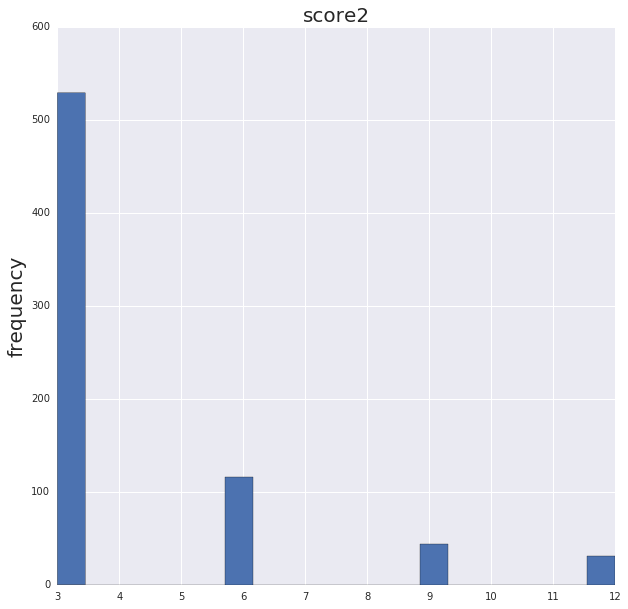

In [6]:
#. visualize numerical variable: score2
fig = plt.figure(figsize=(10,10))
score2 = dataframe['score2']
score2 = score2[score2>0]
plt.hist(score2.values, bins = 20)
plt.ylabel("frequency", fontsize=20)
plt.title('score2', fontsize=20)

2. explore data

In [7]:
#. prepare predictor and dependent variables 
X = dataframe[['score1','score2','category1','category2','category3','category4','category5','category6','category7']]
y = dataframe['labels']

In [8]:
#. imbalanced data sets: SMOT (synthetic minority oversampling technique, Chawla et al., 2002)
print('Original dataset shape: {}'.format(Counter(y)))
smote = SMOTE(kind = "regular")
X_sm, y_sm = smote.fit_sample(X, y)
print('Resampled dataset shape: {}'.format(Counter(y_sm)))

Original dataset shape: Counter({1: 6842, 0: 1261})
Resampled dataset shape: Counter({0: 6842, 1: 6842})


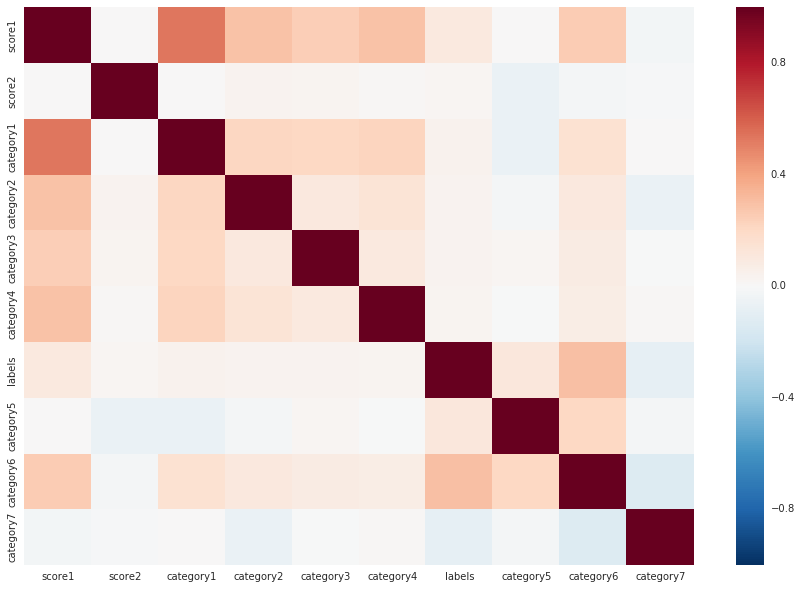

In [9]:
#. intercorrelations among predictor variables.
corr = dataframe.corr()
fig = plt.figure(figsize=(15,10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [10]:
#. PCA(principle component analysis)
#. Pros: reduce complexity of data, identifies most important features
#. Cons: may not be needed, could throw away useful information
#. find the orthogonal components and the linear combinations of these components that can explain the maximum of the variances.
X_PCA = dataframe.dropna(how='any')
y_PCA = dataframe.dropna(how='any')
y_PCA = dataframe[['labels']].dropna(how='any')
pca = decomposition.PCA()
X_PCA_scaled = preprocessing.scale(X_PCA)
y_PCA_scaled = preprocessing.scale(y_PCA)
pca.fit(X_PCA_scaled, y_PCA_scaled)
print('explained variance ratio:', pca.explained_variance_ratio_)
print('explained variance:', pca.explained_variance_)
first_pc = pca.components_[0]
second_pc = pca.components_[1]

explained variance ratio: [ 0.21416135  0.13915107  0.1049189   0.09686953  0.09108964  0.08684692
  0.08316847  0.07620668  0.06320035  0.04438708]
explained variance: [ 2.14161355  1.39151075  1.04918901  0.96869526  0.9108964   0.86846924
  0.83168473  0.76206679  0.63200348  0.4438708 ]


3. build model

In [11]:
#. discards the smallest eigenvalue components.
#. SMOTE resampling for cv
X_cv= dataframe[['score1','category2', 'category3', 'category4', 'category5', 'category6']]
X_sm_cv, y_sm_cv = smote.fit_sample(X_cv, y)

In [12]:
#. optimizing hyperparameters for logistic regression
#. Pros: computational inexpensive, easy to interprete/implement, no distribution required; 
#. Cons: low accuracy, multicolinearity;
param_grid = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
regr = linear_model.LogisticRegression()
CV_regr = GridSearchCV(regr, param_grid)
CV_regr = CV_regr.fit(X_sm_cv, y_sm_cv)
print(CV_regr.best_params_)

{'penalty': 'l2', 'C': 1}


In [13]:
#. logistic regression with ridge regression l2:
#. l2 adds squared magnitude of coefficient as penalty term to the loss function.
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.4, random_state=42)
regr = linear_model.LogisticRegression(penalty = 'l1', C = 0.01)
regr.fit(X_train, y_train)
print('logistic regression coefficients:', regr.coef_)
regr.coef_
print('roc_auc_score:', metrics.roc_auc_score(y_test, regr.predict(X_test)))

logistic regression coefficients: [[-0.00348341  0.04169884  0.          0.          0.         -0.00775386
   0.00403228  0.93628271 -0.09689863]]
roc_auc_score: 0.679904402365


In [ ]:
#. optimizing hyperparameters for SVM
#. Pros: high accuracy, low generalization error, no distribution required;
#. Cons: sensitive to hyperparameters and kernel choice; 
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
scores = ['roc_auc']
for score in scores:
    print("# Tuning hyper-parameters for %s: " % score)
    print()

    clf = GridSearchCV(svm.SVC(C=1), param_grid, cv=6,
                       scoring='%s' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found:")
    print()
    print(clf.best_params_)

In [14]:
#. SVM
clf1 = svm.SVC(kernel='rbf', C=1000, gamma = 0.001)
clf1.fit(X_train, y_train)
pred = clf1.predict(X_test)
print('roc_auc_score:', metrics.roc_auc_score(y_test, pred))

roc_auc_score: 0.688903264139


In [ ]:
#. optimizing hyperparameters for Adaboosting
#. Pros: low generalizaton error.
#. Cons: sensitive to ourliers.
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "n_estimators": [1, 10, 20, 30, 40, 50, 60]
             }
dtc = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "auto",max_depth = None)
ab = AdaBoostClassifier(dtc)

# run grid search
ab = GridSearchCV(ab, param_grid=param_grid, scoring = 'roc_auc')
ab.fit(X_train, y_train)

print("Best parameters set found:")
print()
print(ab.best_params_)

In [15]:
# Adaboosting
ab = AdaBoostClassifier(n_estimators=50)
ab.fit(X_train, y_train)
pred = ab.predict(X_test)
score = ab.score(X_test, y_test)
err = math.sqrt(((pred - y_test)**2).mean())
print('roc_auc_score:', metrics.roc_auc_score(y_test, pred))

roc_auc_score: 0.822236463956


In [16]:
#. cross-validation of random forest
#. k-fold cross-validation: original training set is partitioned into k subsets of size. For each fold, the algorithm is 
# trained on the union of the other folds and then the error of its output is estimated using the fold. The average of all these errors is the estimate of the true error.
#. identify hypterparameters
XX = X_sm_cv
yy = y_sm_cv
n_samples, n_features = XX.shape

#. add some noisy features
random_state = np.random.RandomState(0)
XX = np.c_[XX, random_state.randn(n_samples, 10 * n_features)]

#. run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
classifier = RandomForestClassifier(random_state=0)
rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt', oob_score = True) 

In [ ]:
#. use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63, 72],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
 
CV_rfc = GridSearchCV(estimator=classifier, param_grid=param_grid)
CV_rfc.fit(X, y)
print('optimized hyperparameters are:', CV_rfc.best_params_)

pred ==> [1 0 1 0 0 1 1 0 0 0]
pred_prob ==> [[ 0.11111111  0.88888889]
 [ 1.          0.        ]
 [ 0.          1.        ]
 [ 0.98412698  0.01587302]
 [ 0.98412698  0.01587302]
 [ 0.25396825  0.74603175]
 [ 0.26984127  0.73015873]
 [ 1.          0.        ]
 [ 0.94603175  0.05396825]
 [ 0.92063492  0.07936508]]
             precision    recall  f1-score   support

          0       0.91      0.85      0.88      2775
          1       0.85      0.91      0.88      2699

avg / total       0.88      0.88      0.88      5474

f1_score is ==> 0.880701126811
accuracy score is ==> 0.878151260504
roc_auc_score: predict ==> 0.878617372467
thresholds ==> [2 1 0]
roc_auc ==> 0.878617372467
importances ==> [ 0.13764904  0.01803187  0.0279364   0.16559327  0.13019014  0.10577287
  0.22187134  0.14692517  0.0460299 ]
std ==> [ 0.00991371  0.0027842   0.00810065  0.06591748  0.01940645  0.01394248
  0.0083517   0.05585305  0.01164142]
indices ==> [6 3 7 0 4 5 8 2 1]
Feature ranking:
1. feature 6 (

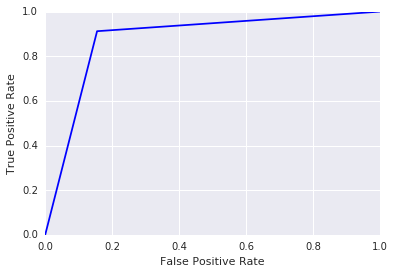

In [17]:
#. Random Forest with pre-set hyperparameters
#. Pros: less likely to overfit, low variance
#. Cons: can overfit with high-cardinality categorical variables
rf = RandomForestClassifier(n_estimators=63, criterion='entropy', random_state=0)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
pred_prob = rf.predict_proba(X_test)
print('pred ==>', pred[0:10])
print('pred_prob ==>', pred_prob[0:10])
metrics.confusion_matrix(y_true=y_test, y_pred=pred)
print(metrics.classification_report(y_true=y_test, y_pred=pred))
print('f1_score is ==>', metrics.f1_score(y_true=y_test,y_pred=pred))
print('accuracy score is ==>', metrics.accuracy_score(y_true=y_test, y_pred=pred))
print('roc_auc_score: predict ==>', metrics.roc_auc_score(y_test, pred))
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, pred)
print('thresholds ==>', thresholds)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print('roc_auc ==>', roc_auc)
plt.plot(false_positive_rate, true_positive_rate, 'b', label="AUC = %0.2f"% roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
print("importances ==>", importances)
print('std ==>', std)
print('indices ==>', indices)
print("Feature ranking:")
for f in range(X_sm.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))    

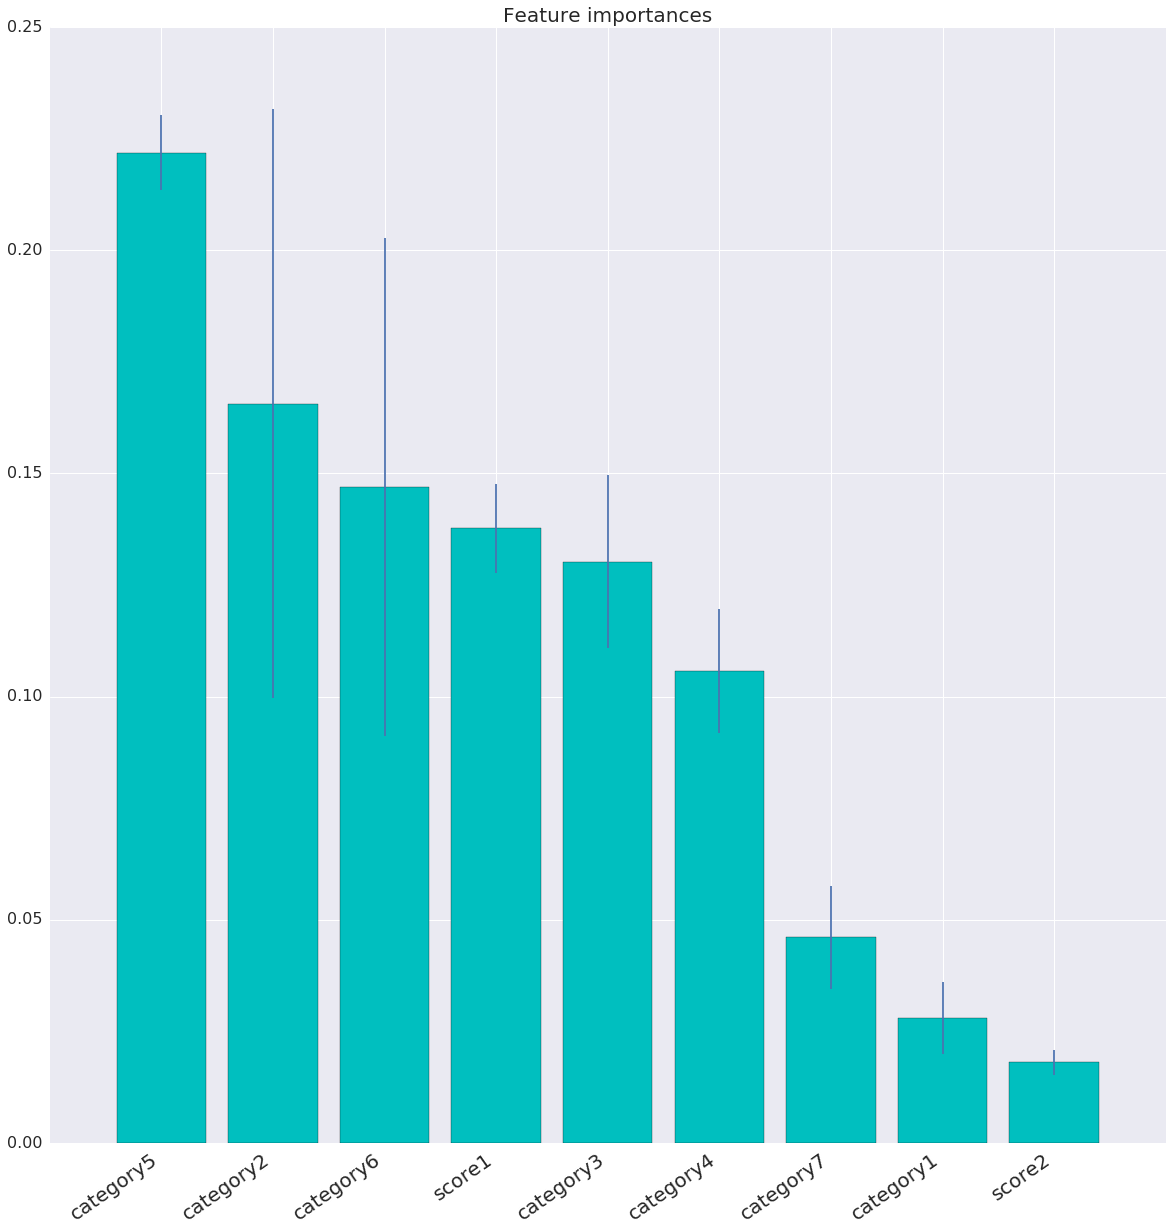

In [18]:
#. plot the feature importances of the forest
indices = np.argsort(importances)[::-1]
LABELS_original = np.array(['score1','score2', 'category1', 'category2', 'category3', 'category4', 'category5', 'category6', 'category7'])
LABELS_end = LABELS_original[indices]
plt.figure(figsize=(20,20))
plt.title("Feature importances", fontsize=20)
plt.yticks(fontsize=16)
plt.bar(range(X_sm.shape[1]), importances[indices],
       color="c", yerr=std[indices], align="center")
plt.xticks(range(X_sm.shape[1]), LABELS_end,rotation=35, fontsize=20, ha='right')
plt.xlim([-1, X_sm.shape[1]])
LABELS_end
plt.savefig('Feature_Importance_test_dataframe.eps', format='eps', dpi=300)

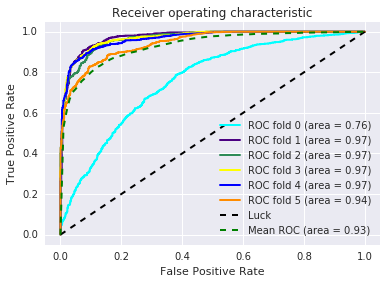

In [19]:
#. set optimized hyperparameters.
#. plot cross-validation roc curves
classifier = RandomForestClassifier(max_depth = 10, min_samples_leaf = 6, n_estimators = 63, criterion = 'entropy', random_state=0)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2
cv = StratifiedKFold(n_splits=6)
i = 0
for (train, test), color in zip(cv.split(X_sm, y_sm), colors):
    probas_ = classifier.fit(X_sm[train], y_sm[train]).predict_proba(X_sm[test])
    fpr, tpr, thresholds = roc_curve(y_sm[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X_sm, y_sm)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_test_dataframe.eps', format='eps', dpi=300)

In [20]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.
    """
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="y")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

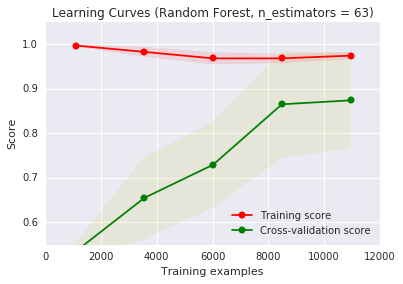

In [21]:
#. learning curve.
#. training score and cross-validation score converge to the approximation error;
#. which is the minimum risk achievable by a predictor in the hypothesis class;
#. measure the risk because we restrict ourselves to a specific class.
title = 'Learning Curves (Random Forest, n_estimators = 63)'
plot_learning_curve(rf, title, X_sm_cv, y_sm_cv, cv=cv)
plt.ylim([0.55,1.05])
plt.savefig('Learning_Curve_test_dataframe.eps', format='eps', dpi=300)